### Import the required modules
- `tensorflow` &mdash; end-to-end framework for tensor operations and automatic differentiation
- `dlmodels` &mdash; local module with the implementations of U-Net, SegNet and DeepLab
- `numpy` &mdash; to manipuilate arrays
- `h5py` &mdash; to read .hdf5 datasets
- `matplotlib` &mdash; to visualise data
- `pandas` &mdash; library to manipulate tabular data
- `os` &mdash; to manipulate pathways
- `tqdm` &mdash; to make progress bars

In [1]:
import tensorflow as tf
import dlmodels
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas
import os
from tqdm import tqdm

### Define constants and access the datasets

In [2]:
DATA_DIR = os.path.join("<path>", "<to>", "<data>")
TRAIN_DATASET_PATH = os.path.join(DATA_DIR, "train_dataset.hdf5")
VAL_DATASET_PATH = os.path.join(DATA_DIR, "val_dataset.hdf5")
TEST_DATASET_PATH = os.path.join(DATA_DIR, "test_dataset.hdf5")

MODEL_WEIGHTS_PATH = "unet_weights.h5"
TRAINING_LOG_PATH = "unet_log.csv"

In [3]:
SUBSET_RATIO = 0.5 # as we are limited in time and resources, let's use only part of the data

BANDS_COUNT = 6 + 2 + 2 # optical bands + dem-slope + 2 SAR intensities (single-pol asc-desc)
CLASSES_COUNT = 2 # glacier + non-glacier

PATCH_SIZE = 256 # size of deep learning model inputs, height=width=patch_size
BATCH_SIZE = 8

MAX_EPOCHS = 500
STEPS = 500

In [4]:
train_dataset = h5py.File(TRAIN_DATASET_PATH, "r")
val_dataset = h5py.File(VAL_DATASET_PATH, "r")
test_dataset = h5py.File(TEST_DATASET_PATH, "r")

### Define data transformations for on-fly processing of the imagery
- `groundtruth_to_onehot` transforms the last channel of an image to one-hot encoding, e.g., 0 -> [1, 0, 0] and 2 -> [0, 0, 1]
- `stretch_features_to_range` stretches the input features into the [0; 1] interval

CNNs are not flip- or rotation-invariant, therefore, we could artificially expand our training datasets by introducing the corresponding random geometrical transformations of the training samples. 

- `random_vertical_flip` randomly applies flips along the vertical axis
- `random_horizontal_flip` randomly applies flips along the horizontal axis
- `random_rotation` randomly rotates an image by 90, 180 or 270 degrees

Note that these functions do not apply transformations directly but produce low-level functions and return them as outputs.

- `apply_transformations` takes a tensor and applies to it passed transformations

In [5]:
def groundtruth_to_onehot():
    def transform(patch):
        height, width, depth = patch.shape
        transformed = np.zeros((height, width, depth - 1 + CLASSES_COUNT))
        transformed[:, :, :-CLASSES_COUNT] = patch[:, :, :-1]
        for class_index in range(CLASSES_COUNT):
            slice_index = class_index - CLASSES_COUNT
            transformed[:, :, slice_index][patch[:, :, -1] == class_index] = 1
        return transformed
    return transform


def stretch_features_to_range(mins, maxs):
    def transform(patch):
        transformed = np.empty(patch.shape)
        transformed[:, :, -CLASSES_COUNT:] = patch[:, :, -CLASSES_COUNT:]
        transformed[:, :, :-CLASSES_COUNT] = (patch[:, :, :-CLASSES_COUNT] - mins) / (maxs - mins)
        return transformed
    return transform


def random_vertical_flip(p=0.5):
    def transform(patch):
        if np.random.random() > p:
            return patch
        transformed = np.flip(patch, axis=0)
        return transformed
    return transform


def random_horizontal_flip(p=0.5):
    def transform(patch):
        if np.random.random() > p:
            return patch
        transformed = np.flip(patch, axis=1)
        return transformed
    return transform


def random_rotation(p=0.5):
    def transform(patch):
        if np.random.random() > p:
            return patch
        k = np.random.choice([1, 2, 3])
        transformed = np.rot90(patch, k, axes=(1, 0))
        return transformed
    return transform


def apply_transformations(patch, transformations):
    if not transformations:
        return patch
    for transformation in transformations:
        patch = transformation(patch)
    return patch

### Data access
Define three helper functions to read the data from the .hdf5 files:

- `get_images_stack` reads different features and groundtruth from a group and stacks them together. Note that not all tiles share common sets of features completely
- `pad_image_to_patch_size` adds 'empty' rows and columns to an image so that it can be divided into patches with the size of `PATCH_SIZE` evenly
- `split_input_features` forms an input object for a neural network by separating different features in a batch so they could be treated as several model inputs

In [6]:
def get_images_stack(tile_data):
    optical = tile_data["optical"]
    height, width, _ = optical.shape
    stack = np.empty((height, width, BANDS_COUNT + 1))
    stack[:, :, 0:6] = optical

    dem = tile_data["dem"]
    stack[:, :, 6] = dem[:, :, 0]
    slope = tile_data["slope"]
    stack[:, :, 7] = slope[:, :, 0]

    co_pol_intensity_asc = tile_data["co_pol_intensity_asc"]
    stack[:, :, 8] = co_pol_intensity_asc[:, :]
    co_pol_intensity_desc = tile_data["co_pol_intensity_desc"]
    stack[:, :, 9] = co_pol_intensity_desc[:, :]

    groundtruth = tile_data["groundtruth"]
    stack[:, :, -1] = groundtruth[:, :, 0]
    
    return stack


def pad_image_to_patch_size(image, patch_size, mins):
    height, width, _ = image.shape
    target_height = patch_size * int(height // patch_size + 1)
    target_width = patch_size * int(width // patch_size + 1)
    pad_height = (target_height - height) // 2
    pad_width = (target_width - width) // 2
    padded = mins[np.newaxis, np.newaxis, :]
    padded = np.repeat(padded, target_height, axis=0)
    padded = np.repeat(padded, target_width, axis=1)
    padded[pad_height:pad_height + height, pad_width:pad_width + width, :] = image
    return padded, (pad_height, pad_width)


def split_input_features(batch_x):
    inputs = {}
    inputs["optical"] = batch_x[:, :, :, [0, 1, 2, 3, 4, 5]]
    inputs["dem"] = batch_x[:, :, :, [6, 7]]
    inputs["sar_intensities"] = batch_x[:, :, :, [8, 9]]
    return inputs

To arrange the data flow for the model training, one of the methods is to implement a class inherited from `tf.keras.utils.Sequence` which serves as a generator. For the training data sequence, we suggest random sampling of tiles and patches from them as implemented below.

In [7]:
class TrainSequence(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size, patch_size, len, transformations=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.len = len
        self.transformations = transformations
        self.index_dataset()

    def index_dataset(self):
        self.images = []

        self.mins = np.empty(BANDS_COUNT)
        self.maxs = np.empty(BANDS_COUNT)
        self.mins[:] = np.inf
        self.maxs[:] = -np.inf
        
        __count = 0
        print("Reading...")
        keys = list(self.dataset.keys())
        keys = np.random.choice(keys, size=int(SUBSET_RATIO * len(keys)), replace=False)
        
        with tqdm(total=len(keys)) as pbar:
            for group in keys:
                tile_data = self.dataset[group]
                if "groundtruth" not in tile_data.keys():
                    pbar.update(1)
                    continue
                    
                stack = get_images_stack(tile_data)

                mins = stack.min(axis=(0, 1))
                maxs = stack.max(axis=(0, 1))
                self.mins = np.minimum(self.mins, mins[:BANDS_COUNT])
                self.maxs = np.maximum(self.maxs, maxs[:BANDS_COUNT])

                self.images.append(stack)
                pbar.update(1)
                __count += 1
                    
        print("Padding...")
        with tqdm(total=len(self.images)) as pbar:
            for image_index in range(len(self.images)):
                image, _ = pad_image_to_patch_size(
                    self.images[image_index], 
                    self.patch_size, 
                    np.concatenate((self.mins, [0]))
                )
                self.images[image_index] = image
                pbar.update(1)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        batch = self.sample()
        batch_x = batch[:, :, :, :-CLASSES_COUNT]
        batch_y = batch[:, :, :, -CLASSES_COUNT:]
        inputs = split_input_features(batch_x)
        return inputs, batch_y

    def sample(self):
        batch = np.empty((self.batch_size, self.patch_size, self.patch_size, BANDS_COUNT + CLASSES_COUNT))
        for patch_index in range(self.batch_size):
            image = self.sample_image()
            patch = self.sample_patch(image)
            patch = apply_transformations(patch, self.transformations)
            batch[patch_index] = patch
        return batch

    def sample_image(self):
        image_index = np.random.choice(len(self.images))
        image = self.images[image_index]
        return image

    def sample_patch(self, image):
        height, width, _ = image.shape
        y = np.random.choice(height - self.patch_size)
        x = np.random.choice(width - self.patch_size)
        patch = image[y:y + self.patch_size, x:x + self.patch_size, :]
        return patch

Let's create an instance of the `TrainSequence` class and visualise its output data.

In [8]:
train_sequence = TrainSequence(train_dataset, BATCH_SIZE, PATCH_SIZE, STEPS)
MINS = train_sequence.mins
MAXS = train_sequence.maxs
train_sequence.transformations = [
    groundtruth_to_onehot(),
    stretch_features_to_range(MINS, MAXS),
    random_vertical_flip(p=0.5),
    random_horizontal_flip(p=0.5),
    random_rotation(p=0.5)
]

Reading...


100%|███████████████████████████████████████████████████████████████| 123/123 [02:14<00:00,  1.09s/it]


Padding...


100%|███████████████████████████████████████████████████████████████| 111/111 [00:03<00:00, 29.90it/s]


[]

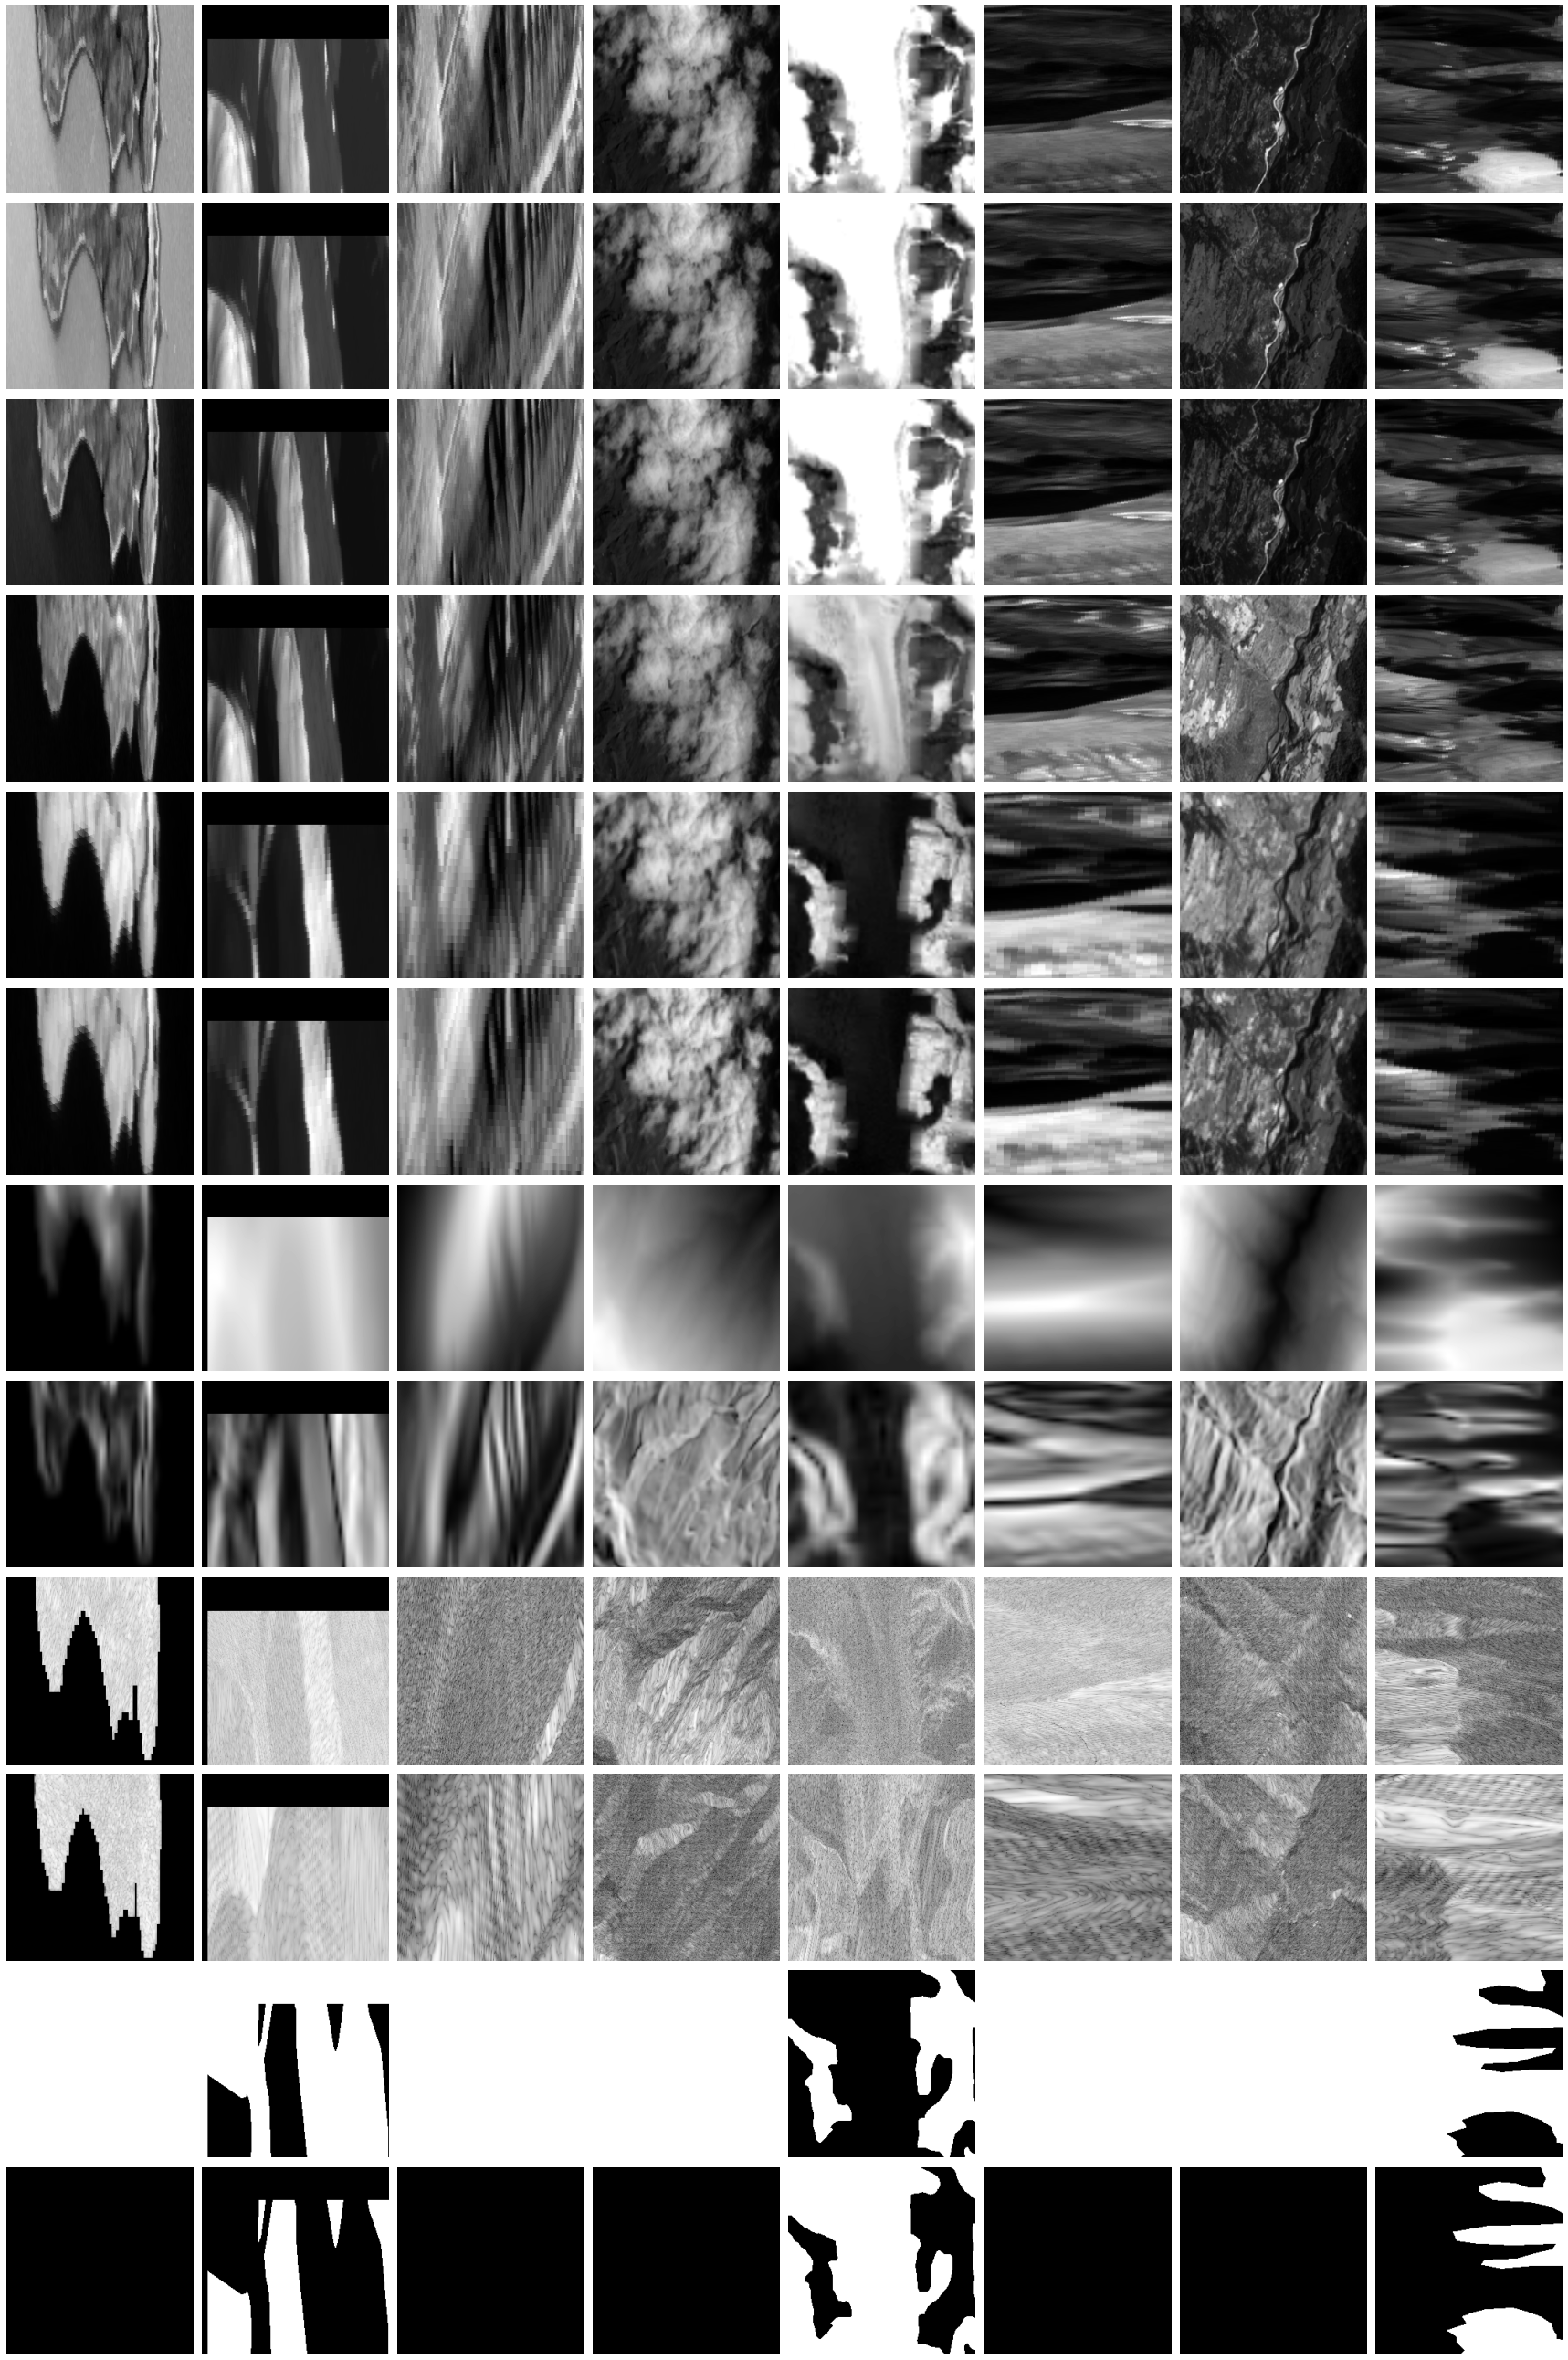

In [9]:
x_, y = train_sequence[0]
x = np.concatenate((x_["optical"], x_["dem"], x_["sar_intensities"]), axis=-1)

nrows, ncols = BANDS_COUNT + CLASSES_COUNT, BATCH_SIZE
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))

for index, (x_item, y_item) in enumerate(zip(x, y)):
    for row in range(BANDS_COUNT):
        axes[row][index].imshow(x_item[:, :, row], cmap="gray")
        axes[row][index].axis("off")
    for class_index in range(CLASSES_COUNT):
        row = BANDS_COUNT + class_index
        axes[row][index].imshow(y_item[:, :, class_index], cmap="gray", vmin=0, vmax=1)
        axes[row][index].axis("off")

plt.tight_layout()
plt.plot()

In a similar manner, we can define a class for the validation subset. But unlike the training one, we would like to make it completely deterministic so no randomness could affect its output as it is needed to compare different model performances on exactly the same data. Thus, instead of random sampling, we employ the running-window sampling of patches.

In [11]:
class ValSequence(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size, patch_size, mins, transformations=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.mins = mins
        self.transformations = transformations
        self.index_dataset()

    def index_dataset(self):              
        self.images = []
        self.len = 0
        
        __count = 0
        print("Reading...")
        keys = list(self.dataset.keys())
        keys = np.random.choice(keys, size=int(SUBSET_RATIO * len(keys)), replace=False)
        
        with tqdm(total=len(keys)) as pbar:
            for group in keys:
                tile_data = self.dataset[group]
                if "groundtruth" not in tile_data.keys():
                    pbar.update(1)
                    continue
                    
                stack = get_images_stack(tile_data)

                self.images.append(stack)
                pbar.update(1)
                __count += 1

        print("Padding...")
        with tqdm(total=len(self.images)) as pbar:
            for image_index in range(len(self.images)):
                image, _ = pad_image_to_patch_size(
                    self.images[image_index], 
                    self.patch_size, 
                    np.concatenate((self.mins, [0]))
                )
                self.images[image_index] = image
                height, width, _ = image.shape
                patches_count = (height // self.patch_size) * (width // self.patch_size)
                self.len += patches_count
                pbar.update(1)

        self.reset()
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        batch = self.sample()
        batch_x = batch[:, :, :, :-CLASSES_COUNT]
        batch_y = batch[:, :, :, -CLASSES_COUNT:]
        inputs = split_input_features(batch_x)
        return inputs, batch_y

    def sample(self):
        batch = np.empty((self.batch_size, self.patch_size, self.patch_size, BANDS_COUNT + CLASSES_COUNT))
        for patch_index in range(self.batch_size):
            patch = self.sample_patch()
            patch = apply_transformations(patch, self.transformations)
            batch[patch_index] = patch
        return batch

    def sample_image(self):
        if self.image_index >= len(self.images):
            self.reset()
        image = self.images[self.image_index]
        return image

    def sample_patch(self):
        image = self.sample_image() 
        height, width, _ = image.shape
        if self.x + self.patch_size > width:
            self.x = 0
            self.y += self.patch_size
        if self.y + self.patch_size > height:
            self.y = 0
            self.x = 0
            self.image_index += 1
            image = self.sample_image()
        patch = image[self.y:self.y + self.patch_size, self.x:self.x + self.patch_size, :]
        self.x += self.patch_size
        return patch
    
    def reset(self):
        self.image_index = 0
        self.x = 0
        self.y = 0

In [12]:
val_sequence = ValSequence(
    val_dataset, BATCH_SIZE, PATCH_SIZE, MINS,
    transformations=[
        groundtruth_to_onehot(),
        stretch_features_to_range(MINS, MAXS)
    ]
)

Reading...


100%|█████████████████████████████████████████████████████████████████| 44/44 [00:46<00:00,  1.06s/it]


Padding...


100%|█████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 30.45it/s]


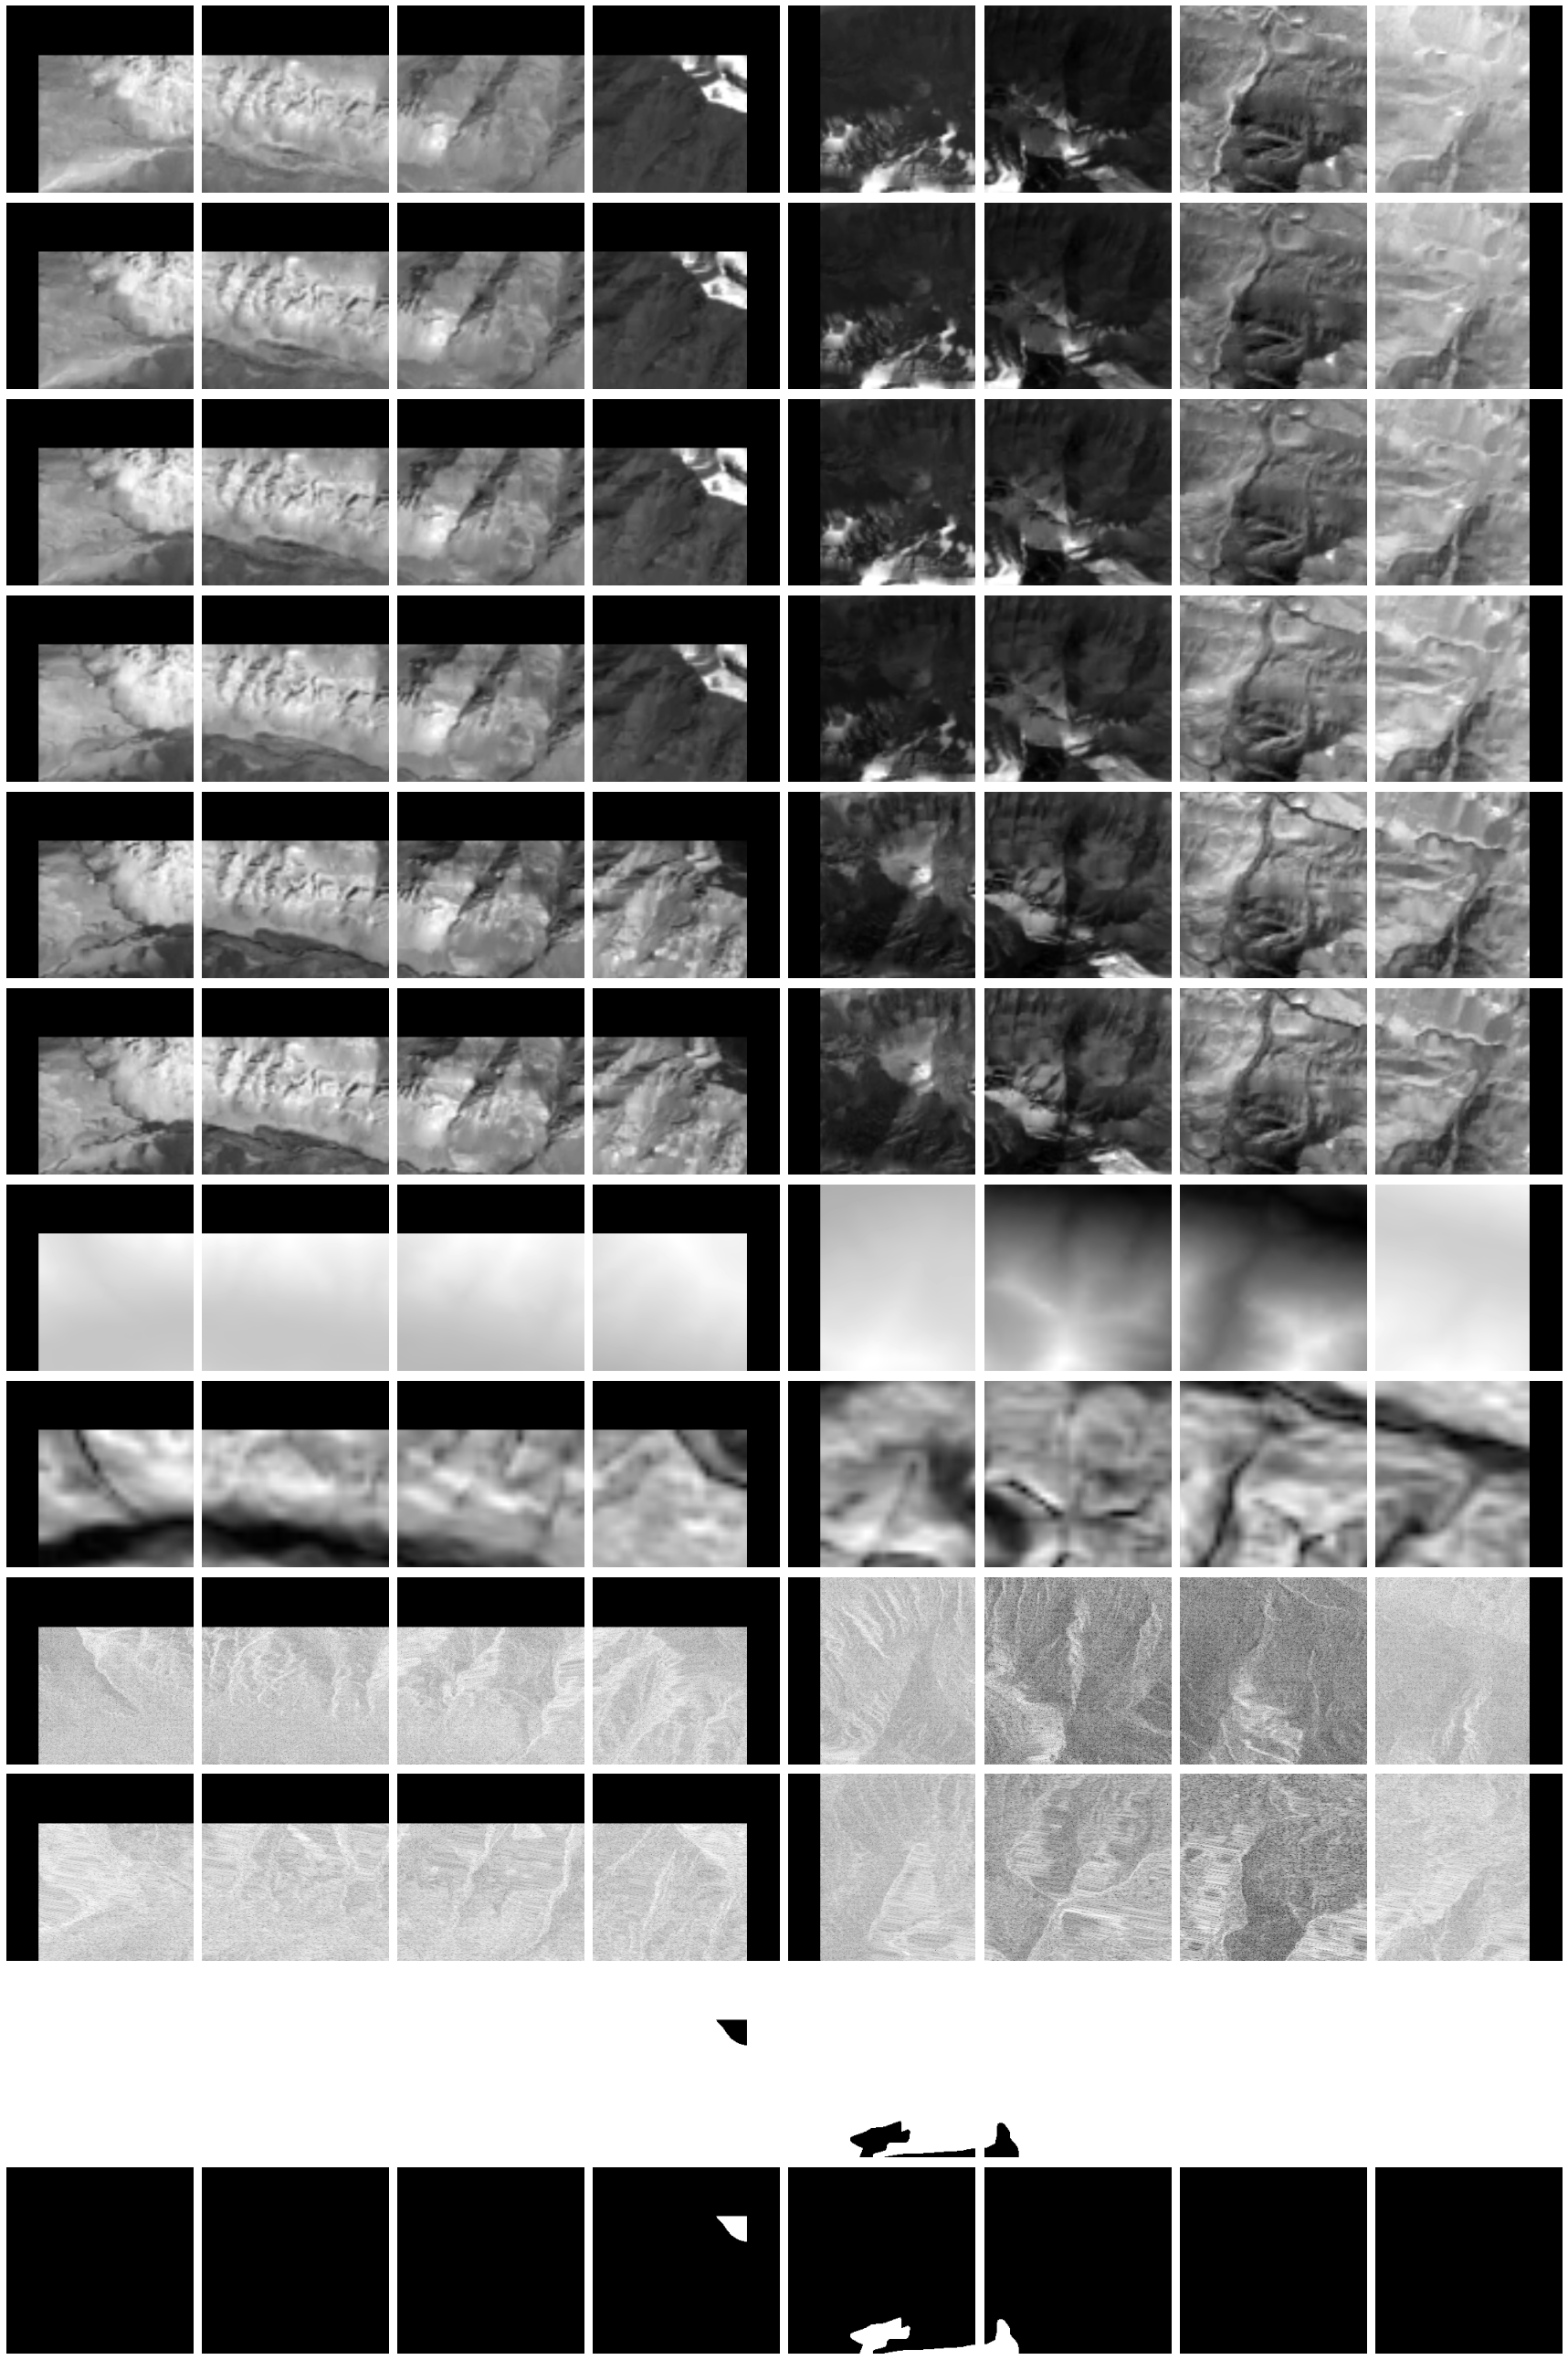

In [13]:
x_, y = val_sequence[0]
x = np.concatenate((x_["optical"], x_["dem"], x_["sar_intensities"]), axis=-1)

nrows, ncols = BANDS_COUNT + CLASSES_COUNT, BATCH_SIZE
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))

for index, (x_item, y_item) in enumerate(zip(x, y)):
    for row in range(BANDS_COUNT):
        axes[row][index].imshow(x_item[:, :, row], cmap="gray")
        axes[row][index].axis("off")
    for class_index in range(CLASSES_COUNT):
        row = BANDS_COUNT + class_index
        axes[row][index].imshow(y_item[:, :, class_index], cmap="gray", vmin=0, vmax=1)
        axes[row][index].axis("off")

plt.tight_layout()
plt.show()

Reset `val_sequence` now to reuse it later for model evaluation during training.

In [14]:
val_sequence.reset()

### Model definition and training
At the same folder where you found this notebook, you can find a small python module called `dlmodels` that contains implementation of three deep learning models &mdash; U-Net, SegNet and DeepLabV3+. You can access them as `dlmodels.unet`, `dlmodels.segnet` and `dlmodels.deeplab`. Feel free to copy the implementations, change the code and see how it affects your results.

Let's start with U-Net.

In [55]:
model = dlmodels.unet(
    {
        "optical": (PATCH_SIZE, PATCH_SIZE, 6),
        "dem": (PATCH_SIZE, PATCH_SIZE, 2),
        "sar_intensities": (PATCH_SIZE, PATCH_SIZE, 2)
    }, CLASSES_COUNT
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 optical (InputLayer)           [(None, 256, 256, 6  0           []                               
                                )]                                                                
                                                                                                  
 dem (InputLayer)               [(None, 256, 256, 2  0           []                               
                                )]                                                                
                                                                                                  
 sar_intensities (InputLayer)   [(None, 256, 256, 2  0           []                               
                                )]                                                          

Define the optimization algorithm, loss function and metrics to track during the training with the `compile` method.

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        *[
            tf.keras.metrics.Precision(class_id=class_index) 
            for class_index in range(CLASSES_COUNT)
        ],
        *[
            tf.keras.metrics.Recall(class_id=class_index) 
            for class_index in range(CLASSES_COUNT)
        ]
    ]
)

Often it is beneficial to keep an eye on how your loss and metrics are changing during the training. Thus, you can save the best weights of your model, make a training log and stop the training (or decrease the learning rate) when it comes to a 'plateau'.

In [16]:
training_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        MODEL_WEIGHTS_PATH,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True
    ),
    tf.keras.callbacks.CSVLogger(
        TRAINING_LOG_PATH
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=1,
        restore_best_weights=True
    )
]

And, finally, we can start training (fitting) our model.

In [17]:
model.fit(
    train_sequence,
    epochs=MAX_EPOCHS,
    validation_data=val_sequence,
    callbacks=training_callbacks
)

Epoch 1/500


2022-08-31 11:14:20.600142: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-08-31 11:14:21.620108: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-31 11:14:21.620845: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-31 11:14:21.620873: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-31 11:14:21.621634: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-31 11:14:21.621730: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


500/500 [==============================] - ETA: 0s - loss: 0.2196 - categorical_accuracy: 0.9186 - precision: 0.9432 - precision_1: 0.8442 - recall: 0.9481 - recall_1: 0.8314

2022-08-31 11:20:30.227472: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: pretrained_deeplab/assets


/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 387s 754ms/step - loss: 0.2196 - categorical_accuracy: 0.9186 - precision: 0.9432 - precision_1: 0.8442 - recall: 0.9481 - recall_1: 0.8314 - val_loss: 0.1651 - val_categorical_accuracy: 0.9500 - val_precision: 0.9676 - val_precision_1: 0.8901 - val_recall: 0.9675 - val_recall_1: 0.8907
Epoch 2/500
500/500 [==============================] - 372s 745ms/step - loss: 0.1375 - categorical_accuracy: 0.9510 - precision: 0.9628 - precision_1: 0.9152 - recall: 0.9718 - recall_1: 0.8901 - val_loss: 0.3340 - val_categorical_accuracy: 0.8555 - val_precision: 0.9463 - val_precision_1: 0.6407 - val_recall: 0.8614 - val_recall_1: 0.8353
Epoch 3/500
500/500 [==============================] - ETA: 0s - loss: 0.1104 - categorical_accuracy: 0.9590 - precision: 0.9683 - precision_1: 0.9295 - recall: 0.9774 - recall_1: 0.9035INFO:tensorflow:Assets written to: pretrained_deeplab/assets


/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 390s 781ms/step - loss: 0.1104 - categorical_accuracy: 0.9590 - precision: 0.9683 - precision_1: 0.9295 - recall: 0.9774 - recall_1: 0.9035 - val_loss: 0.1045 - val_categorical_accuracy: 0.9590 - val_precision: 0.9714 - val_precision_1: 0.9157 - val_recall: 0.9754 - val_recall_1: 0.9034
Epoch 4/500
500/500 [==============================] - ETA: 0s - loss: 0.1105 - categorical_accuracy: 0.9586 - precision: 0.9696 - precision_1: 0.9240 - recall: 0.9758 - recall_1: 0.9059INFO:tensorflow:Assets written to: pretrained_deeplab/assets


/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 376s 754ms/step - loss: 0.1105 - categorical_accuracy: 0.9586 - precision: 0.9696 - precision_1: 0.9240 - recall: 0.9758 - recall_1: 0.9059 - val_loss: 0.1033 - val_categorical_accuracy: 0.9627 - val_precision: 0.9661 - val_precision_1: 0.9495 - val_recall: 0.9861 - val_recall_1: 0.8834
Epoch 5/500
500/500 [==============================] - 441s 882ms/step - loss: 0.1030 - categorical_accuracy: 0.9612 - precision: 0.9714 - precision_1: 0.9278 - recall: 0.9775 - recall_1: 0.9099 - val_loss: 0.8773 - val_categorical_accuracy: 0.8192 - val_precision: 0.9607 - val_precision_1: 0.5662 - val_recall: 0.7983 - val_recall_1: 0.8900
Epoch 6/500
500/500 [==============================] - 354s 709ms/step - loss: 0.1039 - categorical_accuracy: 0.9601 - precision: 0.9708 - precision_1: 0.9263 - recall: 0.9765 - recall_1: 0.9100 - val_loss: 0.8584 - val_categorical_accuracy: 0.8298 - val_precision: 0.9514 - val_precision_1: 0.5871 - val_recall: 0.8214 - val_

/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 376s 752ms/step - loss: 0.0971 - categorical_accuracy: 0.9623 - precision: 0.9731 - precision_1: 0.9276 - recall: 0.9772 - recall_1: 0.9157 - val_loss: 0.0926 - val_categorical_accuracy: 0.9662 - val_precision: 0.9674 - val_precision_1: 0.9610 - val_recall: 0.9894 - val_recall_1: 0.8879
Epoch 8/500
500/500 [==============================] - ETA: 0s - loss: 0.0918 - categorical_accuracy: 0.9647 - precision: 0.9746 - precision_1: 0.9327 - recall: 0.9790 - recall_1: 0.9194INFO:tensorflow:Assets written to: pretrained_deeplab/assets


/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 393s 787ms/step - loss: 0.0918 - categorical_accuracy: 0.9647 - precision: 0.9746 - precision_1: 0.9327 - recall: 0.9790 - recall_1: 0.9194 - val_loss: 0.0844 - val_categorical_accuracy: 0.9684 - val_precision: 0.9750 - val_precision_1: 0.9450 - val_recall: 0.9843 - val_recall_1: 0.9151
Epoch 9/500
500/500 [==============================] - ETA: 0s - loss: 0.0947 - categorical_accuracy: 0.9635 - precision: 0.9730 - precision_1: 0.9342 - recall: 0.9783 - recall_1: 0.9192INFO:tensorflow:Assets written to: pretrained_deeplab/assets


/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 386s 772ms/step - loss: 0.0947 - categorical_accuracy: 0.9635 - precision: 0.9730 - precision_1: 0.9342 - recall: 0.9783 - recall_1: 0.9192 - val_loss: 0.0756 - val_categorical_accuracy: 0.9701 - val_precision: 0.9801 - val_precision_1: 0.9357 - val_recall: 0.9811 - val_recall_1: 0.9329
Epoch 10/500
500/500 [==============================] - 360s 721ms/step - loss: 0.0917 - categorical_accuracy: 0.9646 - precision: 0.9739 - precision_1: 0.9349 - recall: 0.9793 - recall_1: 0.9192 - val_loss: 0.2173 - val_categorical_accuracy: 0.9403 - val_precision: 0.9373 - val_precision_1: 0.9529 - val_recall: 0.9887 - val_recall_1: 0.7769
Epoch 11/500
500/500 [==============================] - 361s 724ms/step - loss: 0.0877 - categorical_accuracy: 0.9662 - precision: 0.9750 - precision_1: 0.9393 - recall: 0.9798 - recall_1: 0.9261 - val_loss: 0.0858 - val_categorical_accuracy: 0.9663 - val_precision: 0.9721 - val_precision_1: 0.9452 - val_recall: 0.9845 - va

/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 371s 743ms/step - loss: 0.0841 - categorical_accuracy: 0.9673 - precision: 0.9766 - precision_1: 0.9392 - recall: 0.9796 - recall_1: 0.9309 - val_loss: 0.0748 - val_categorical_accuracy: 0.9704 - val_precision: 0.9837 - val_precision_1: 0.9262 - val_recall: 0.9777 - val_recall_1: 0.9455
Epoch 15/500
500/500 [==============================] - ETA: 0s - loss: 0.0776 - categorical_accuracy: 0.9691 - precision: 0.9776 - precision_1: 0.9429 - recall: 0.9813 - recall_1: 0.9323INFO:tensorflow:Assets written to: pretrained_deeplab/assets


/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 369s 740ms/step - loss: 0.0776 - categorical_accuracy: 0.9691 - precision: 0.9776 - precision_1: 0.9429 - recall: 0.9813 - recall_1: 0.9323 - val_loss: 0.0745 - val_categorical_accuracy: 0.9705 - val_precision: 0.9721 - val_precision_1: 0.9640 - val_recall: 0.9900 - val_recall_1: 0.9045
Epoch 16/500
500/500 [==============================] - 361s 723ms/step - loss: 0.0806 - categorical_accuracy: 0.9685 - precision: 0.9769 - precision_1: 0.9428 - recall: 0.9812 - recall_1: 0.9305 - val_loss: 0.0775 - val_categorical_accuracy: 0.9705 - val_precision: 0.9830 - val_precision_1: 0.9284 - val_recall: 0.9785 - val_recall_1: 0.9433
Epoch 17/500
500/500 [==============================] - ETA: 0s - loss: 0.0779 - categorical_accuracy: 0.9693 - precision: 0.9779 - precision_1: 0.9429 - recall: 0.9813 - recall_1: 0.9333INFO:tensorflow:Assets written to: pretrained_deeplab/assets


/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 373s 746ms/step - loss: 0.0779 - categorical_accuracy: 0.9693 - precision: 0.9779 - precision_1: 0.9429 - recall: 0.9813 - recall_1: 0.9333 - val_loss: 0.0723 - val_categorical_accuracy: 0.9726 - val_precision: 0.9791 - val_precision_1: 0.9496 - val_recall: 0.9855 - val_recall_1: 0.9293
Epoch 18/500
500/500 [==============================] - ETA: 0s - loss: 0.0796 - categorical_accuracy: 0.9689 - precision: 0.9774 - precision_1: 0.9421 - recall: 0.9816 - recall_1: 0.9296INFO:tensorflow:Assets written to: pretrained_deeplab/assets


/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 374s 749ms/step - loss: 0.0796 - categorical_accuracy: 0.9689 - precision: 0.9774 - precision_1: 0.9421 - recall: 0.9816 - recall_1: 0.9296 - val_loss: 0.0664 - val_categorical_accuracy: 0.9735 - val_precision: 0.9843 - val_precision_1: 0.9372 - val_recall: 0.9813 - val_recall_1: 0.9474
Epoch 19/500
500/500 [==============================] - 367s 736ms/step - loss: 0.0723 - categorical_accuracy: 0.9715 - precision: 0.9788 - precision_1: 0.9491 - recall: 0.9831 - recall_1: 0.9372 - val_loss: 0.0679 - val_categorical_accuracy: 0.9730 - val_precision: 0.9861 - val_precision_1: 0.9299 - val_recall: 0.9788 - val_recall_1: 0.9536
Epoch 20/500
500/500 [==============================] - 391s 784ms/step - loss: 0.0796 - categorical_accuracy: 0.9689 - precision: 0.9781 - precision_1: 0.9399 - recall: 0.9809 - recall_1: 0.9318 - val_loss: 0.0827 - val_categorical_accuracy: 0.9677 - val_precision: 0.9779 - val_precision_1: 0.9323 - val_recall: 0.9802 - va

/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 382s 765ms/step - loss: 0.0731 - categorical_accuracy: 0.9712 - precision: 0.9791 - precision_1: 0.9459 - recall: 0.9828 - recall_1: 0.9350 - val_loss: 0.0642 - val_categorical_accuracy: 0.9747 - val_precision: 0.9809 - val_precision_1: 0.9526 - val_recall: 0.9863 - val_recall_1: 0.9355
Epoch 26/500
500/500 [==============================] - 372s 744ms/step - loss: 0.0752 - categorical_accuracy: 0.9702 - precision: 0.9783 - precision_1: 0.9458 - recall: 0.9818 - recall_1: 0.9361 - val_loss: 0.0653 - val_categorical_accuracy: 0.9739 - val_precision: 0.9832 - val_precision_1: 0.9422 - val_recall: 0.9829 - val_recall_1: 0.9434
Epoch 27/500
500/500 [==============================] - 351s 704ms/step - loss: 0.0723 - categorical_accuracy: 0.9717 - precision: 0.9796 - precision_1: 0.9473 - recall: 0.9830 - recall_1: 0.9374 - val_loss: 0.0716 - val_categorical_accuracy: 0.9724 - val_precision: 0.9796 - val_precision_1: 0.9471 - val_recall: 0.9846 - va

/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 372s 744ms/step - loss: 0.0690 - categorical_accuracy: 0.9729 - precision: 0.9812 - precision_1: 0.9454 - recall: 0.9835 - recall_1: 0.9382 - val_loss: 0.0637 - val_categorical_accuracy: 0.9752 - val_precision: 0.9826 - val_precision_1: 0.9495 - val_recall: 0.9852 - val_recall_1: 0.9414
Epoch 29/500
500/500 [==============================] - ETA: 0s - loss: 0.0687 - categorical_accuracy: 0.9727 - precision: 0.9807 - precision_1: 0.9470 - recall: 0.9834 - recall_1: 0.9390INFO:tensorflow:Assets written to: pretrained_deeplab/assets


/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 373s 747ms/step - loss: 0.0687 - categorical_accuracy: 0.9727 - precision: 0.9807 - precision_1: 0.9470 - recall: 0.9834 - recall_1: 0.9390 - val_loss: 0.0624 - val_categorical_accuracy: 0.9752 - val_precision: 0.9827 - val_precision_1: 0.9494 - val_recall: 0.9852 - val_recall_1: 0.9417
Epoch 30/500
500/500 [==============================] - 359s 718ms/step - loss: 0.0699 - categorical_accuracy: 0.9728 - precision: 0.9805 - precision_1: 0.9475 - recall: 0.9837 - recall_1: 0.9379 - val_loss: 0.0641 - val_categorical_accuracy: 0.9750 - val_precision: 0.9838 - val_precision_1: 0.9450 - val_recall: 0.9838 - val_recall_1: 0.9456
Epoch 31/500
500/500 [==============================] - ETA: 0s - loss: 0.0689 - categorical_accuracy: 0.9730 - precision: 0.9806 - precision_1: 0.9499 - recall: 0.9834 - recall_1: 0.9420INFO:tensorflow:Assets written to: pretrained_deeplab/assets


/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 368s 737ms/step - loss: 0.0689 - categorical_accuracy: 0.9730 - precision: 0.9806 - precision_1: 0.9499 - recall: 0.9834 - recall_1: 0.9420 - val_loss: 0.0612 - val_categorical_accuracy: 0.9760 - val_precision: 0.9832 - val_precision_1: 0.9511 - val_recall: 0.9857 - val_recall_1: 0.9433
Epoch 32/500
500/500 [==============================] - 369s 738ms/step - loss: 0.0703 - categorical_accuracy: 0.9718 - precision: 0.9801 - precision_1: 0.9463 - recall: 0.9825 - recall_1: 0.9397 - val_loss: 0.0617 - val_categorical_accuracy: 0.9753 - val_precision: 0.9784 - val_precision_1: 0.9641 - val_recall: 0.9898 - val_recall_1: 0.9265
Epoch 33/500
500/500 [==============================] - 364s 729ms/step - loss: 0.0673 - categorical_accuracy: 0.9731 - precision: 0.9805 - precision_1: 0.9493 - recall: 0.9841 - recall_1: 0.9387 - val_loss: 0.0637 - val_categorical_accuracy: 0.9748 - val_precision: 0.9839 - val_precision_1: 0.9439 - val_recall: 0.9834 - va

/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 387s 775ms/step - loss: 0.0677 - categorical_accuracy: 0.9732 - precision: 0.9806 - precision_1: 0.9498 - recall: 0.9839 - recall_1: 0.9401 - val_loss: 0.0596 - val_categorical_accuracy: 0.9763 - val_precision: 0.9823 - val_precision_1: 0.9555 - val_recall: 0.9871 - val_recall_1: 0.9401
Epoch 38/500
500/500 [==============================] - 374s 749ms/step - loss: 0.0683 - categorical_accuracy: 0.9727 - precision: 0.9805 - precision_1: 0.9489 - recall: 0.9831 - recall_1: 0.9416 - val_loss: 0.0624 - val_categorical_accuracy: 0.9756 - val_precision: 0.9807 - val_precision_1: 0.9575 - val_recall: 0.9878 - val_recall_1: 0.9347
Epoch 39/500
500/500 [==============================] - 357s 715ms/step - loss: 0.0713 - categorical_accuracy: 0.9722 - precision: 0.9802 - precision_1: 0.9482 - recall: 0.9826 - recall_1: 0.9417 - val_loss: 0.0620 - val_categorical_accuracy: 0.9760 - val_precision: 0.9850 - val_precision_1: 0.9452 - val_recall: 0.9837 - va

/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 398s 798ms/step - loss: 0.0684 - categorical_accuracy: 0.9726 - precision: 0.9799 - precision_1: 0.9505 - recall: 0.9835 - recall_1: 0.9401 - val_loss: 0.0584 - val_categorical_accuracy: 0.9770 - val_precision: 0.9841 - val_precision_1: 0.9521 - val_recall: 0.9859 - val_recall_1: 0.9467
Epoch 45/500
500/500 [==============================] - 356s 712ms/step - loss: 0.0641 - categorical_accuracy: 0.9744 - precision: 0.9816 - precision_1: 0.9526 - recall: 0.9842 - recall_1: 0.9454 - val_loss: 0.0675 - val_categorical_accuracy: 0.9732 - val_precision: 0.9740 - val_precision_1: 0.9697 - val_recall: 0.9916 - val_recall_1: 0.9110
Epoch 46/500
500/500 [==============================] - 375s 751ms/step - loss: 0.0673 - categorical_accuracy: 0.9734 - precision: 0.9805 - precision_1: 0.9525 - recall: 0.9837 - recall_1: 0.9439 - val_loss: 0.0600 - val_categorical_accuracy: 0.9762 - val_precision: 0.9803 - val_precision_1: 0.9614 - val_recall: 0.9890 - va

/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 380s 761ms/step - loss: 0.0642 - categorical_accuracy: 0.9743 - precision: 0.9814 - precision_1: 0.9529 - recall: 0.9843 - recall_1: 0.9445 - val_loss: 0.0582 - val_categorical_accuracy: 0.9766 - val_precision: 0.9869 - val_precision_1: 0.9420 - val_recall: 0.9826 - val_recall_1: 0.9564
Epoch 49/500
500/500 [==============================] - 359s 718ms/step - loss: 0.0640 - categorical_accuracy: 0.9745 - precision: 0.9813 - precision_1: 0.9547 - recall: 0.9843 - recall_1: 0.9466 - val_loss: 0.0611 - val_categorical_accuracy: 0.9759 - val_precision: 0.9789 - val_precision_1: 0.9648 - val_recall: 0.9900 - val_recall_1: 0.9282
Epoch 50/500
500/500 [==============================] - 371s 742ms/step - loss: 0.0663 - categorical_accuracy: 0.9735 - precision: 0.9808 - precision_1: 0.9515 - recall: 0.9837 - recall_1: 0.9436 - val_loss: 0.0593 - val_categorical_accuracy: 0.9765 - val_precision: 0.9811 - val_precision_1: 0.9600 - val_recall: 0.9885 - va

/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 379s 759ms/step - loss: 0.0631 - categorical_accuracy: 0.9749 - precision: 0.9821 - precision_1: 0.9525 - recall: 0.9846 - recall_1: 0.9455 - val_loss: 0.0571 - val_categorical_accuracy: 0.9775 - val_precision: 0.9833 - val_precision_1: 0.9569 - val_recall: 0.9874 - val_recall_1: 0.9438
Epoch 54/500
500/500 [==============================] - 374s 748ms/step - loss: 0.0607 - categorical_accuracy: 0.9757 - precision: 0.9823 - precision_1: 0.9550 - recall: 0.9856 - recall_1: 0.9455 - val_loss: 0.0599 - val_categorical_accuracy: 0.9760 - val_precision: 0.9798 - val_precision_1: 0.9619 - val_recall: 0.9891 - val_recall_1: 0.9317
Epoch 55/500
500/500 [==============================] - ETA: 0s - loss: 0.0591 - categorical_accuracy: 0.9759 - precision: 0.9830 - precision_1: 0.9542 - recall: 0.9851 - recall_1: 0.9483INFO:tensorflow:Assets written to: pretrained_deeplab/assets


/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 392s 785ms/step - loss: 0.0591 - categorical_accuracy: 0.9759 - precision: 0.9830 - precision_1: 0.9542 - recall: 0.9851 - recall_1: 0.9483 - val_loss: 0.0565 - val_categorical_accuracy: 0.9773 - val_precision: 0.9848 - val_precision_1: 0.9514 - val_recall: 0.9857 - val_recall_1: 0.9489
Epoch 56/500
500/500 [==============================] - 364s 729ms/step - loss: 0.0617 - categorical_accuracy: 0.9750 - precision: 0.9824 - precision_1: 0.9525 - recall: 0.9843 - recall_1: 0.9471 - val_loss: 0.0571 - val_categorical_accuracy: 0.9770 - val_precision: 0.9853 - val_precision_1: 0.9487 - val_recall: 0.9848 - val_recall_1: 0.9505
Epoch 57/500
500/500 [==============================] - 360s 721ms/step - loss: 0.0612 - categorical_accuracy: 0.9754 - precision: 0.9825 - precision_1: 0.9534 - recall: 0.9849 - recall_1: 0.9463 - val_loss: 0.0572 - val_categorical_accuracy: 0.9770 - val_precision: 0.9819 - val_precision_1: 0.9593 - val_recall: 0.9882 - va

/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 375s 751ms/step - loss: 0.0612 - categorical_accuracy: 0.9756 - precision: 0.9824 - precision_1: 0.9545 - recall: 0.9850 - recall_1: 0.9473 - val_loss: 0.0563 - val_categorical_accuracy: 0.9772 - val_precision: 0.9854 - val_precision_1: 0.9491 - val_recall: 0.9850 - val_recall_1: 0.9510
Epoch 63/500
500/500 [==============================] - 358s 718ms/step - loss: 0.0602 - categorical_accuracy: 0.9755 - precision: 0.9824 - precision_1: 0.9533 - recall: 0.9854 - recall_1: 0.9442 - val_loss: 0.0594 - val_categorical_accuracy: 0.9765 - val_precision: 0.9852 - val_precision_1: 0.9466 - val_recall: 0.9842 - val_recall_1: 0.9505
Epoch 64/500
500/500 [==============================] - 351s 702ms/step - loss: 0.0593 - categorical_accuracy: 0.9761 - precision: 0.9828 - precision_1: 0.9551 - recall: 0.9856 - recall_1: 0.9467 - val_loss: 0.0592 - val_categorical_accuracy: 0.9761 - val_precision: 0.9818 - val_precision_1: 0.9562 - val_recall: 0.9873 - va

/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 374s 750ms/step - loss: 0.0623 - categorical_accuracy: 0.9755 - precision: 0.9823 - precision_1: 0.9547 - recall: 0.9852 - recall_1: 0.9462 - val_loss: 0.0555 - val_categorical_accuracy: 0.9776 - val_precision: 0.9858 - val_precision_1: 0.9496 - val_recall: 0.9851 - val_recall_1: 0.9525
Epoch 69/500
500/500 [==============================] - ETA: 0s - loss: 0.0583 - categorical_accuracy: 0.9766 - precision: 0.9835 - precision_1: 0.9536 - recall: 0.9861 - recall_1: 0.9452INFO:tensorflow:Assets written to: pretrained_deeplab/assets


/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 366s 734ms/step - loss: 0.0583 - categorical_accuracy: 0.9766 - precision: 0.9835 - precision_1: 0.9536 - recall: 0.9861 - recall_1: 0.9452 - val_loss: 0.0550 - val_categorical_accuracy: 0.9776 - val_precision: 0.9868 - val_precision_1: 0.9464 - val_recall: 0.9840 - val_recall_1: 0.9558
Epoch 70/500
500/500 [==============================] - ETA: 0s - loss: 0.0585 - categorical_accuracy: 0.9764 - precision: 0.9836 - precision_1: 0.9527 - recall: 0.9854 - recall_1: 0.9475INFO:tensorflow:Assets written to: pretrained_deeplab/assets


/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 375s 752ms/step - loss: 0.0585 - categorical_accuracy: 0.9764 - precision: 0.9836 - precision_1: 0.9527 - recall: 0.9854 - recall_1: 0.9475 - val_loss: 0.0548 - val_categorical_accuracy: 0.9779 - val_precision: 0.9852 - val_precision_1: 0.9527 - val_recall: 0.9861 - val_recall_1: 0.9503
Epoch 71/500
500/500 [==============================] - 354s 709ms/step - loss: 0.0606 - categorical_accuracy: 0.9755 - precision: 0.9826 - precision_1: 0.9523 - recall: 0.9852 - recall_1: 0.9447 - val_loss: 0.0567 - val_categorical_accuracy: 0.9773 - val_precision: 0.9868 - val_precision_1: 0.9454 - val_recall: 0.9837 - val_recall_1: 0.9559
Epoch 72/500
500/500 [==============================] - 359s 718ms/step - loss: 0.0608 - categorical_accuracy: 0.9761 - precision: 0.9830 - precision_1: 0.9543 - recall: 0.9853 - recall_1: 0.9477 - val_loss: 0.0583 - val_categorical_accuracy: 0.9770 - val_precision: 0.9807 - val_precision_1: 0.9636 - val_recall: 0.9896 - va

/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 378s 756ms/step - loss: 0.0612 - categorical_accuracy: 0.9754 - precision: 0.9825 - precision_1: 0.9531 - recall: 0.9850 - recall_1: 0.9461 - val_loss: 0.0543 - val_categorical_accuracy: 0.9781 - val_precision: 0.9854 - val_precision_1: 0.9528 - val_recall: 0.9861 - val_recall_1: 0.9512
Epoch 81/500
500/500 [==============================] - ETA: 0s - loss: 0.0591 - categorical_accuracy: 0.9764 - precision: 0.9833 - precision_1: 0.9551 - recall: 0.9852 - recall_1: 0.9497INFO:tensorflow:Assets written to: pretrained_deeplab/assets


/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 382s 766ms/step - loss: 0.0591 - categorical_accuracy: 0.9764 - precision: 0.9833 - precision_1: 0.9551 - recall: 0.9852 - recall_1: 0.9497 - val_loss: 0.0541 - val_categorical_accuracy: 0.9781 - val_precision: 0.9872 - val_precision_1: 0.9475 - val_recall: 0.9844 - val_recall_1: 0.9573
Epoch 82/500
500/500 [==============================] - ETA: 0s - loss: 0.0568 - categorical_accuracy: 0.9773 - precision: 0.9840 - precision_1: 0.9563 - recall: 0.9858 - recall_1: 0.9515INFO:tensorflow:Assets written to: pretrained_deeplab/assets


/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/konstantin/.conda/envs/massive-tf/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


500/500 [==============================] - 379s 759ms/step - loss: 0.0568 - categorical_accuracy: 0.9773 - precision: 0.9840 - precision_1: 0.9563 - recall: 0.9858 - recall_1: 0.9515 - val_loss: 0.0537 - val_categorical_accuracy: 0.9784 - val_precision: 0.9864 - val_precision_1: 0.9510 - val_recall: 0.9855 - val_recall_1: 0.9545
Epoch 83/500
500/500 [==============================] - 367s 734ms/step - loss: 0.0587 - categorical_accuracy: 0.9764 - precision: 0.9835 - precision_1: 0.9528 - recall: 0.9855 - recall_1: 0.9467 - val_loss: 0.0558 - val_categorical_accuracy: 0.9776 - val_precision: 0.9836 - val_precision_1: 0.9564 - val_recall: 0.9873 - val_recall_1: 0.9449
Epoch 84/500
500/500 [==============================] - 354s 710ms/step - loss: 0.0586 - categorical_accuracy: 0.9762 - precision: 0.9829 - precision_1: 0.9556 - recall: 0.9854 - recall_1: 0.9483 - val_loss: 0.0570 - val_categorical_accuracy: 0.9773 - val_precision: 0.9819 - val_precision_1: 0.9611 - val_recall: 0.9888 - va

### Visualising training history
Having a look at the changes of loss and metrics during the training can offer more insights about over- or under-fitting of a model and more.

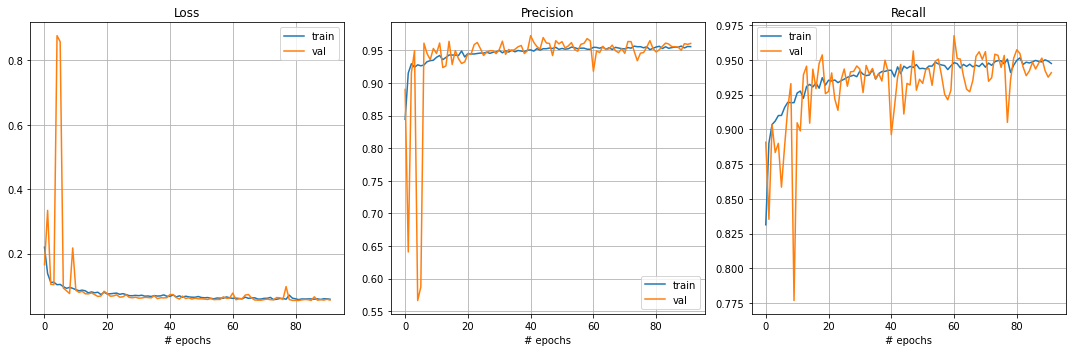

In [56]:
history = pandas.read_csv(TRAINING_LOG_PATH)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].set_title("Loss")
axes[0].plot(history["loss"], label="train")
axes[0].plot(history["val_loss"], label="val")
axes[0].set_xlabel("# epochs")
axes[0].grid()
axes[0].legend()

axes[1].set_title("Precision")
axes[1].plot(history["precision_1"], label="train")
axes[1].plot(history["val_precision_1"], label="val")
axes[1].set_xlabel("# epochs")
axes[1].grid()
axes[1].legend()

axes[2].set_title("Recall")
axes[2].plot(history["recall_1"], label="train")
axes[2].plot(history["val_recall_1"], label="val")
axes[2].set_xlabel("# epochs")
axes[2].grid()
axes[2].legend()

plt.tight_layout()
plt.show()

### Test tile classification and reporting model performance
To classify test tiles, we extract the patches from them in a moving-window manner with overlaps (as we expect the performance to drop near the patch edges), classify each patch and combine them back together to produce final classification results.
For each tile, we keep track on the values of `TP`, `TN`, `FP` and `FN` to calculate the metrics showing the model performace:

$Precision = \frac{TP}{TP + FP} , $

$Recall = \frac{TP}{TP + FN} , $

$F1 = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall} , $

$IoU = \frac{TP}{TP + FP + FN} . $

First, let's load the model weights. This step is not needed if you already trained your own model in this session.

In [57]:
model.load_weights(MODEL_WEIGHTS_PATH)

And classify test tiles row by row.

In [58]:
transformations = [
    groundtruth_to_onehot(),
    stretch_features_to_range(MINS, MAXS)
]

results = {}

with tqdm(total=len(test_dataset.keys())) as pbar:
    for group in test_dataset.keys():
        tile_data = test_dataset[group]
        if "groundtruth" not in tile_data.keys():
            pbar.update(1)
            continue

        stack = get_images_stack(tile_data)
        original_height, original_width, _ = stack.shape
        stack, (pad_height, pad_width) = pad_image_to_patch_size(
            stack, PATCH_SIZE, np.concatenate((MINS, [0]))
        )
        height, width, _ = stack.shape
        
        stack = apply_transformations(stack, transformations)
        features = stack[:, :, :BANDS_COUNT]
        prediction = np.zeros((height, width, CLASSES_COUNT))
        
        row = 0
        while row + PATCH_SIZE <= height:
            row_patches = []
            
            col = 0 
            while col + PATCH_SIZE <= width:
                patch = features[row:row + PATCH_SIZE, col:col + PATCH_SIZE, :]
                row_patches.append(patch)
                col += (PATCH_SIZE // 2)
            
            batch = np.array(row_patches)
            batch = split_input_features(batch)
            row_predictions = model.predict(batch)
            
            col, patch_idx = 0, 0
            while col + PATCH_SIZE <= width:
                prediction[row:row + PATCH_SIZE, col:col + PATCH_SIZE, :] += \
                    row_predictions[patch_idx]
                col += (PATCH_SIZE // 2)
                patch_idx += 1
            
            row += (PATCH_SIZE // 2)
            
        prediction = prediction[
            pad_height:pad_height + original_height,
            pad_width:pad_width + original_width, :
        ]
        prediction = np.argmax(prediction, axis=-1)
        
        results[group] = prediction
                            
        pbar.update(1)

100%|███████████████████████████████████████████████████████████████| 178/178 [06:16<00:00,  2.11s/it]


In [59]:
tp, tn, fp, fn = 0, 0, 0, 0

with tqdm(total=len(results)) as pbar:
    for group, prediction in results.items():
        groundtruth = test_dataset[group]["groundtruth"][:, :, 0]
        
        tp_mask = (prediction == 1) & (groundtruth == 1)
        tn_mask = (prediction == 0) & (groundtruth == 0)
        fp_mask = (prediction == 1) & (groundtruth == 0)
        fn_mask = (prediction == 0) & (groundtruth == 1)
        
        tp += np.sum(tp_mask)
        tn += np.sum(tn_mask)
        fp += np.sum(fp_mask)
        fn += np.sum(fn_mask)
        
        pbar.update(1)
        
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
iou = tp / (tp + fp + fn)

100%|██████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 100.44it/s]


In [60]:
print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"f1-score = {f1}")
print(f"iou = {iou}")

precision = 0.956697120605607
recall = 0.9569304102511995
f1-score = 0.9568137512082747
iou = 0.9172031862157963


### Visualising some of the tiles
Here we are visualising the predictions for some tiles from the test set. However, instead of looking at a predefined set of tiles, it could be beneficial to analyse which ones were the most challenging to classify.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


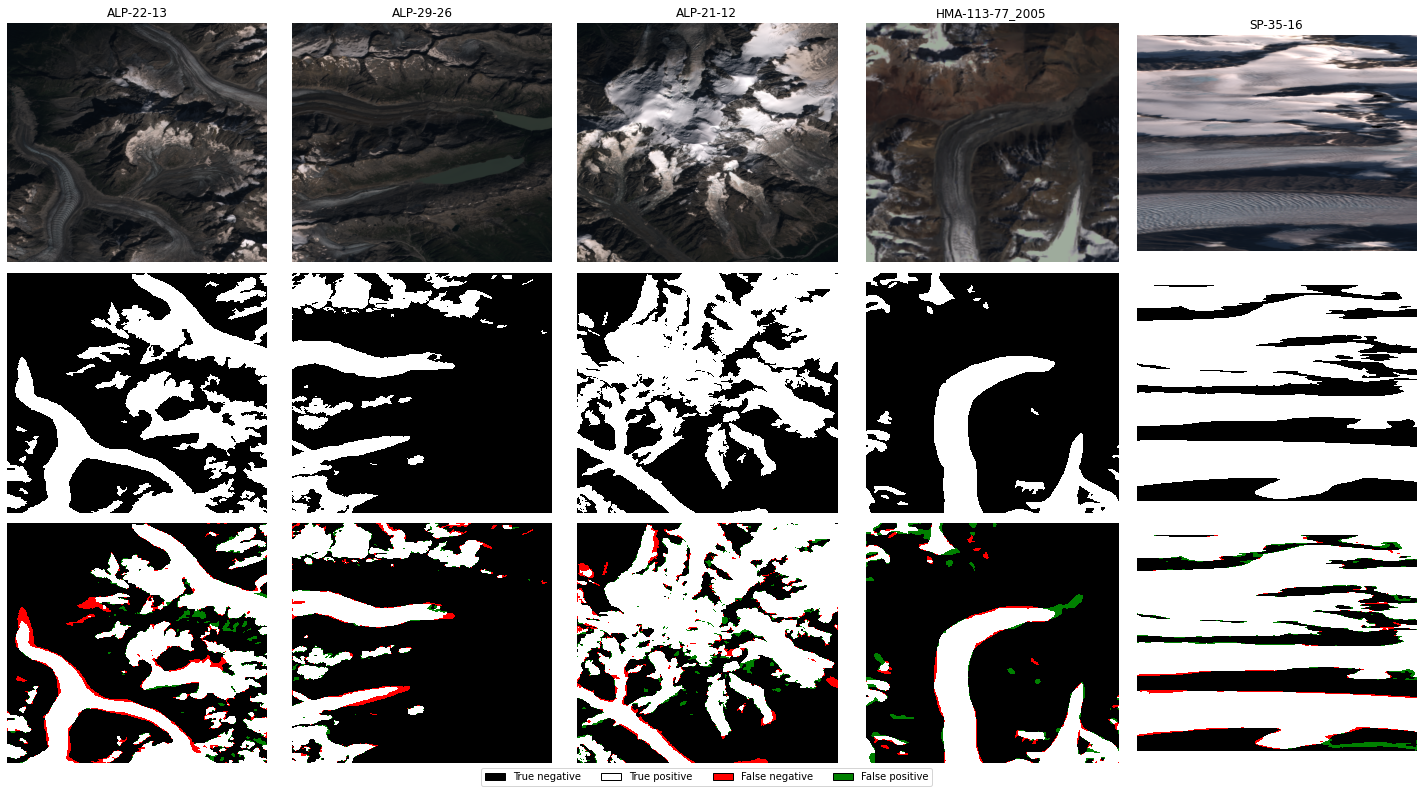

In [61]:
tiles_to_visualise = ["ALP-22-13", "ALP-29-26", "ALP-21-12", "HMA-113-77_2005", "SP-35-16"]

nrows, ncols = 3, len(tiles_to_visualise)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3.6*nrows))

for col, tile in enumerate(tiles_to_visualise):
    rgb = np.array(test_dataset[tile]["optical"])[:, :, [2, 1, 0]]
    
    axes[0][col].set_title(tile)
    axes[0][col].imshow(rgb, vmin=0., vmax=0.3)
    
    groundtruth = np.array(test_dataset[tile]["groundtruth"])[:, :, 0]
    axes[1][col].imshow(groundtruth, cmap="gray", interpolation="none")
    
    output_colors = ["black", "white", "red", "green"]
    output_cmap = mpl.colors.ListedColormap(output_colors, 4)
      
    predicted = results[tile]
    output = np.zeros(predicted.shape)
    output[(predicted == 1) & (groundtruth == 1)] = 1
    output[(predicted == 0) & (groundtruth == 1)] = 2
    output[(predicted == 1) & (groundtruth == 0)] = 3
    axes[2][col].imshow(output / 3, cmap=output_cmap, interpolation="none")

for row in range(nrows):
    for col in range(ncols):
        axes[row][col].axis("off")
    
labels = ["True negative", "True positive", "False negative", "False positive"]
handles = [mpl.patches.Patch(facecolor=_, edgecolor="black") for _ in output_colors]

fig.legend(handles, labels, ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.022))

plt.tight_layout()
plt.show()

Clean after yourself a bit. :)

Usually it is not strictly necessary if you terminate your session properly, we left this cell just in case if it is really needed to close the dataset files at some point.

In [62]:
train_dataset.close()
val_dataset.close()
test_dataset.close()